# ELAN stock price analysis and predictions
---

## Step 1
## Comparing ELAN and LLY performance
## Using Monte Carlo simulations to predict ELAN stock cumulative returns in 5 years with historical data.

In [2]:
# Import the required libraries and dependencies
import os
import requests
import json
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from Resources.MCForecastTools import MCSimulation

%matplotlib inline

In [3]:
# Load .env environment variables
load_dotenv()

True

In [4]:
# Set the variables for the Alpaca API and secret keys
alpaca_api_key = os.getenv('ALPACA_API_KEY')
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [5]:
# Create the Alpaca tradeapi.REST object
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [6]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers = ['ELAN', 'LLY']
# Set timeframe to 1Day
timeframe = '1Day'

# Set start and end dates of 4 years back from my current date using ISO standard
new_start_date = pd.Timestamp('2018-09-20', tz='America/New_York').isoformat()
new_end_date = pd.Timestamp('2022-06-21', tz='America/New_York').isoformat()

# Use the Alpaca get_bars function to make the API call to get the 3 years worth of pricing data
prices_years_df = alpaca.get_bars(
    tickers,
    timeframe,
    start=new_start_date,
    end=new_end_date,
).df

# Reorganize the DataFrame
# Separate ticker data into their respective tickers
ELAN = prices_years_df[prices_years_df['symbol']=='ELAN'].drop('symbol', axis=1)
LLY = prices_years_df[prices_years_df['symbol']=='LLY'].drop('symbol', axis=1)

# Concatenate the ticker DataFrames
prices_df = pd.concat([ELAN,LLY], axis=1, keys= ['ELAN', 'LLY'])
# For new prices dataframe, keep only the date component
prices_df.index = prices_df.index.date

# Display both the first and last five rows of the DataFrame
prices_df


ELAN                                                          \
             open    high     low  close    volume trade_count       vwap   
2018-09-20  32.25  36.010  32.050  36.00  40361374      143964  33.254328   
2018-09-21  34.62  35.490  33.875  34.10   9269454       42435  34.578275   
2018-09-24  34.00  35.650  33.700  34.90   2769119       15499  34.805860   
2018-09-25  34.76  34.990  34.060  34.58   3152188       17008  34.519008   
2018-09-26  34.35  35.980  34.250  35.50   5835634       17846  35.363765   
...           ...     ...     ...    ...       ...         ...        ...   
2022-06-14  21.63  21.680  20.695  20.90   3819861       33373  20.987218   
2022-06-15  21.00  21.270  20.430  20.92   4270127       34005  20.913077   
2022-06-16  20.42  20.480  19.585  20.28   9269722       48385  20.189644   
2022-06-17  20.44  20.910  20.300  20.55   5917810       35147  20.624154   
2022-06-21  20.89  20.925  19.970  20.03   9190317       42317  20.223487   

               LLY                                                             
              open     high      low   close   volume trade_count        vwap  
2018-09-20  105.61  106.110  104.220  106.07  3761098       30386  105.625212  
2018-09-21  106.31  106.870  105.350  106.33  5346289       22501  106.375052  
2018-09-24  106.01  106.670  105.590  105.59  3093693       22132  105.797489  
2018-09-25  106.01  106.755  105.540  105.70  3776926       26999  106.038150  
2018-09-26  106.15  107.370  106.005  106.31  3707259       28527  106.562224  
...            ...      ...      ...     ...      ...         ...         ...  
2022-06-14  289.17  292.000  287.290  290.79  2411941       48749  289.633529  
2022-06-15  291.60  296.340  288.530  292.99  1958723       38956  292.516454  
2022-06-16  289.61  290.200  283.110  288.07  2610334       52331  287.335556  
2022-06-17  290.55  300.990  289.680  290.90  6853561       72060  292.697196  
2022-06-21  293.08  299.280  290.310  297.34  2805430       47627  297.311177  

[944 rows x 14 columns]

In [7]:
# Get the closing prices
closing_prices_df = pd.DataFrame()
closing_prices_df["ELAN"] = prices_df['ELAN']["close"]
closing_prices_df["LLY"] = prices_df['LLY']["close"]
# Drop the time component of the date
# closing_prices_df.index = closing_prices_df.index.date
closing_prices_df

,ELAN,LLY
2018-09-20,36.00,106.07
2018-09-21,34.10,106.33
2018-09-24,34.90,105.59
2018-09-25,34.58,105.70
2018-09-26,35.50,106.31
...,...,...
2022-06-14,20.90,290.79
2022-06-15,20.92,292.99
2022-06-16,20.28,288.07
2022-06-17,20.55,290.90


<AxesSubplot:title={'center':'Daily Returns of ELAN & LLY - 2018-2022'}>

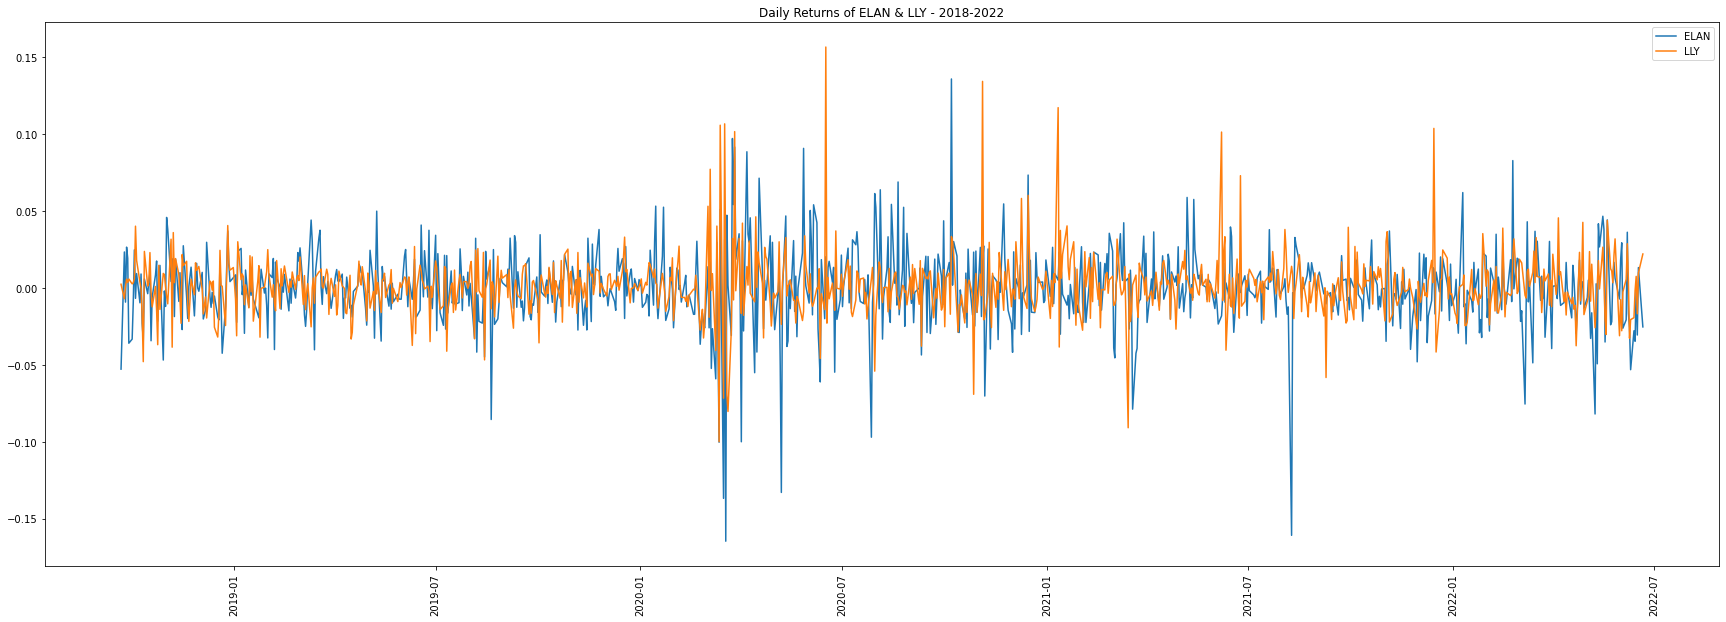

In [8]:
# Compute daily returns
daily_returns_df = closing_prices_df.pct_change().dropna()
# Plot daily returns
daily_returns_df.plot(figsize=(30, 10), title="Daily Returns of ELAN & LLY - 2018-2022", rot=90)

## Price were steady for both ELAN and LLY before 2020. Higher volatility appeared during 2020 March -2021 March. Major price drop for ELAN around August 2021. ELAN shows higher volatility than LLY in 2022.
---

In [9]:
# Generate summary statistics for the `daily_returns_df` DataFrame
daily_returns_df.describe()

,ELAN,LLY
count,943.000000,943.000000
mean,-0.000299,0.001293
std,0.025241,0.020132
min,-0.164747,-0.099986
25%,-0.012554,-0.008384
50%,-0.000340,0.001222
75%,0.012015,0.009597
max,0.136026,0.156798


<AxesSubplot:title={'center':'Probability Distribution'}, ylabel='Frequency'>

<AxesSubplot:title={'center':'Probability Distribution'}, ylabel='Frequency'>

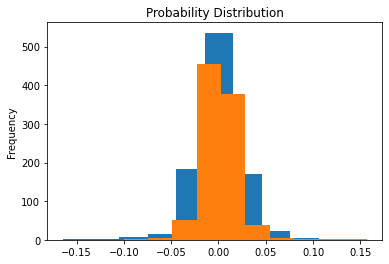

In [10]:
# Visualize distribution of ELAN percent change in closing price using a histogram plot
elan_hist = daily_returns_df['ELAN'].plot.hist(title='Probability Distribution')
lly_hist = daily_returns_df['LLY'].plot.hist(title='Probability Distribution')

display(elan_hist)
display(lly_hist)

## Most price movements of both ELAN and LLY lie within a standard deviation of +/- 0.05
## Overall volatility is medium.
## LLY has more positive price movements than ELAN

<AxesSubplot:title={'center':'Density Plot for ELAN'}, ylabel='Density'>

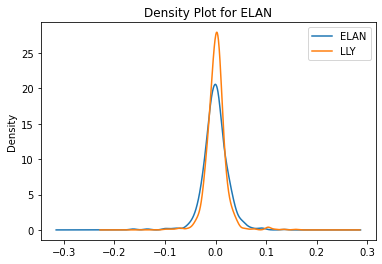

In [11]:
# Calling the plot.density function on the daily_returns_df DataFrame.
daily_returns_df.plot.density(title='Density Plot for ELAN')

## ELAN has high frequency of small daily changes
---

### Run Monte Carlo Simulations to predict 95% confidence interval cumulative return of ELAN in 5 years

In [12]:
# Configure the Monte Carlo simulation to forecast 5 years cumulative returns
# Run 500 samples.
MC = MCSimulation(
    portfolio_data = prices_df,
    weights = [1,0],
    num_simulation = 500,
    num_trading_days = 252*5
)
# Review the simulation input data
MC.portfolio_data.head()


ELAN                                                         \
             open   high     low  close    volume trade_count       vwap   
2018-09-20  32.25  36.01  32.050  36.00  40361374      143964  33.254328   
2018-09-21  34.62  35.49  33.875  34.10   9269454       42435  34.578275   
2018-09-24  34.00  35.65  33.700  34.90   2769119       15499  34.805860   
2018-09-25  34.76  34.99  34.060  34.58   3152188       17008  34.519008   
2018-09-26  34.35  35.98  34.250  35.50   5835634       17846  35.363765   

                            LLY                                     \
           daily_return    open     high      low   close   volume   
2018-09-20          NaN  105.61  106.110  104.220  106.07  3761098   
2018-09-21    -0.052778  106.31  106.870  105.350  106.33  5346289   
2018-09-24     0.023460  106.01  106.670  105.590  105.59  3093693   
2018-09-25    -0.009169  106.01  106.755  105.540  105.70  3776926   
2018-09-26     0.026605  106.15  107.370  106.005  106.31  3707259   

                                                 
           trade_count        vwap daily_return  
2018-09-20       30386  105.625212          NaN  
2018-09-21       22501  106.375052     0.002451  
2018-09-24       22132  105.797489    -0.006959  
2018-09-25       26999  106.038150     0.001042  
2018-09-26       28527  106.562224     0.005771

In [13]:
# Run the Monte Carlo simulation to forecast 5 years cumulative returns
MC.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.


/Users/yjun_ln/Desktop/ELAN/Resources/MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo simulation number 230.
Running Monte Carlo simulation number 240.
Running Monte Carlo simulation number 250.
Running Monte Carlo simulation number 260.
Running Monte Carlo simulation number 270.
Running Monte Carlo simulation number 280.
Running Monte Carlo simulation number 290.
Running Monte Carlo simulation number 300.
Running Monte Carlo simulation number 310.
Running Monte Carlo simulation number 320.
Running Monte Carlo simulation number 330.
Running Mon

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.971444,0.984696,0.968997,1.027542,0.984303,0.929014,1.012188,0.999161,1.013104,0.998645,...,0.988540,1.007924,0.954788,0.958324,1.012901,1.020800,0.996584,0.999846,1.030936,1.026120
2,0.964140,0.939080,1.003381,0.986458,1.005506,0.920105,1.062928,0.982199,0.979016,1.005231,...,1.030206,0.991112,0.983551,0.977062,1.028707,1.082548,1.007907,0.963332,0.995985,1.032920
3,0.939211,0.936157,0.995434,0.977961,0.980986,0.889424,1.086895,0.963912,0.961371,0.987983,...,0.987021,1.003360,0.951896,0.977528,1.020446,1.098969,0.982413,0.979522,0.965288,1.037966
4,0.943305,0.968119,1.024493,0.997171,0.998108,0.934497,1.123190,0.932289,0.940417,0.997894,...,0.976394,0.998587,0.954294,0.975671,1.032371,1.148226,1.018763,0.952761,0.968066,1.029041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.301444,0.155004,0.305133,0.824550,0.664997,1.621498,0.613459,0.350200,0.140332,0.782016,...,0.845385,0.792994,0.109289,0.581298,1.343468,0.144129,0.248520,0.789247,0.553236,0.202229
1257,0.312413,0.148089,0.309673,0.840779,0.654196,1.604636,0.578129,0.345669,0.137265,0.781526,...,0.861203,0.797299,0.112233,0.567233,1.280790,0.143043,0.237196,0.799440,0.561896,0.198089
1258,0.312708,0.148131,0.314546,0.827923,0.637872,1.574000,0.559818,0.339829,0.143573,0.792423,...,0.806138,0.802081,0.109763,0.545849,1.231068,0.140858,0.237301,0.779957,0.576525,0.185717
1259,0.309580,0.147780,0.307960,0.832875,0.637555,1.544588,0.559096,0.336975,0.146109,0.821469,...,0.802409,0.809765,0.110078,0.549040,1.256396,0.139708,0.234146,0.779535,0.567776,0.188570


<AxesSubplot:title={'center':'500 Simulations of Cumulative Portfolio Return Trajectories Over the Next 1260 Trading Days.'}>

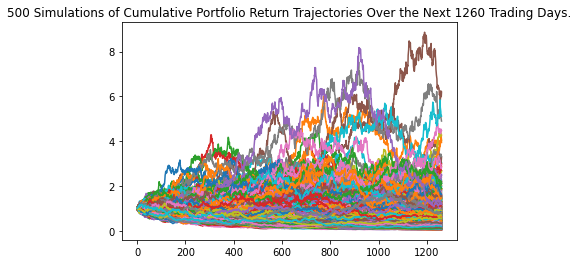

In [15]:
# Visualize the 30-year Monte Carlo simulation by creating an overlay line plot
MC.plot_simulation()


#### Step 3: Plot the probability distribution of the Monte Carlo simulation.

<AxesSubplot:title={'center':'Distribution of Final Cumuluative Returns Across All 500 Simulations'}, ylabel='Frequency'>

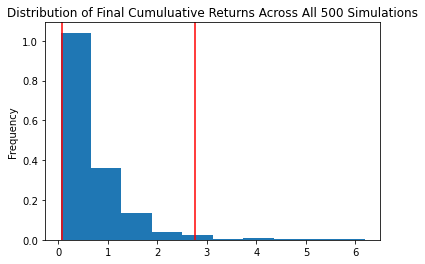

In [16]:
# Visualize the probability distribution of the 5-year Monte Carlo simulation by plotting a histogram
MC.plot_distribution()


#### Step 4: Generate the summary statistics for the Monte Carlo simulation.

In [17]:
# Generate summary statistics from the 5-year Monte Carlo simulation results
# Save the results as a variable
table = MC.summarize_cumulative_return()


# Review the 5-year Monte Carlo summary statistics
table

count           500.000000
mean              0.705412
std               0.743833
min               0.043323
25%               0.251253
50%               0.490628
75%               0.867525
max               6.191254
95% CI Lower      0.077106
95% CI Upper      2.755833
Name: 1260, dtype: float64

In [18]:
lower = round(table[8],2)
higher = round(table[9],2)
# Print the result of calculations
print(f'The lower bounds for the expected cumulative return of ELAN with a 95% confidence interval is {lower}%')
print(f'The higher bounds for the expected cumulative return of ELAN with a 95% confidence interval is {higher}%')

The lower bounds for the expected cumulative return of ELAN with a 95% confidence interval is 0.08%
The higher bounds for the expected cumulative return of ELAN with a 95% confidence interval is 2.76%


## There are 95% chance, in the next 5 years, ELAN's cumulative return on investment will fall between 0.08% and 2.76%.
---